# Tutorial III - Effect of the angular resolution on the observed velocity curves

In [ ]:
from cubes3D import plot_velocity, plot_sigma
from IPython.display import Image
import numpy as np
import numpy.ma as ma
import astropy.units as u
from astropy.io import fits
from astropy.constants import c
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline 


import warnings
from spectral_cube.utils import SpectralCubeWarning
warnings.filterwarnings(action='ignore', category=SpectralCubeWarning,
                        append=True)


## Make velocity fields from the cubes

Use the function `Fit_line`, developed this morning, to fit the $H\alpha$ line of the three simulated cubes.
 - SINFONI no-AO : 'Data/cube_SINFONI.fits'
 - SINFONI with AO : 'Data/cube_SINFONI_AO.fits'
 - HARMONI:  'Data/cube_HARMONI.fits'
 
The cube data is in extension 0 of the fits file. Start by computing the redshfit of the galaxy: 
$z = \frac{(\lambda_{obs} - \lambda_{rest})}{\lambda_{rest}}$

In [ ]:
from galaxy_spec import Rest_spectrum, Fit_line, SaveMaps

#def Fit_cubes_singleLine(file, redshift, fileout, name ='Halpha'):
#
#     to be completed
#
#    SaveMaps(line_map, name = name, fileout=fileout )

### SINFONI without AO

In [ ]:
redshift = 2.4003

file = 'Data/cube_SINFONI.fits'
fileout =  'Data/cube_SINFONI/Ha_SINFONI.fits'

Fit_cubes_singleLine(file, redshift, fileout = fileout, name ='Halpha')

In [ ]:
Sinfoni_maps = fits.open(fileout)
Sinfoni_lc = ma.masked_where((Sinfoni_maps[5].data < 5) | (Sinfoni_maps[6].data < 1), Sinfoni_maps[1].data)
Sinfoni_vel =  (c.to(u.km / u.s).value ) * (Sinfoni_lc - 6562.)/6562.
plot_velocity(Sinfoni_vel, vel_min_scale  = -80, vel_max_scale = 100 )

Sinfoni_width = ma.masked_where((Sinfoni_maps[5].data < 5) | (Sinfoni_maps[6].data < 1), Sinfoni_maps[2].data)
Sinfoni_sigma =  (c.to(u.km / u.s).value ) * (Sinfoni_width)/6562.
plot_sigma(Sinfoni_sigma, sigma_min_scale = 120.0, sigma_max_scale = 150 )

### SINFONI with AO

In [ ]:
# Repeat for the SINFONI AO cube

### Harmoni - ELT

In [ ]:
# and also for the HARMONI cube

## Plot the velocity curves

For each simulated observation, extract the velocity curves, both velocity and dispersion, along the kinematic major axis of the galaxy (major gradient). 



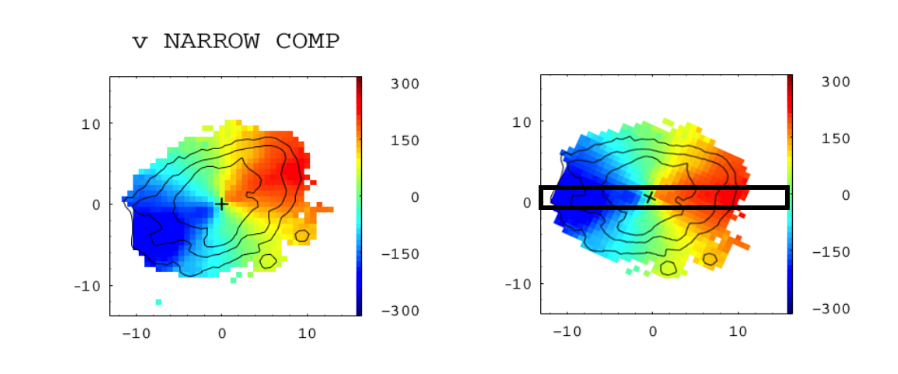

In [33]:
Image(filename='Velocity_field_rot.png')

For simplicity, you can rotate the original velocity field (left panel) to align the kinematic major axis with the "x" axis of the image. The result is shown in the right panel.

Then, you can extract the velocity of the central row of the image (black box in the right hand panel) to obtain the rotation curve of the galaxy.

Tip: You can use the function `ndimage.rotate` to rotate the maps

In [ ]:
from scipy import ndimage, misc
# e.g., ndimage.rotate(velocity_field, angle, order=0, reshape=True, cval=np.nan)


Compare the amplitude of the rotation curves and the sigma peak value of the three simulations

## Correct for the beam-smearing

"GalPaK 3D is a tool to extract the intrinsic (i.e. deconvolved) Galaxy Parameters and Kinematics from any 3-Dimensional data. The algorithm uses a disk parametric model with 10 free parameters (which can also be fixed independently) and a MCMC approach with non-traditional sampling laws in order to efficiently probe the parameter space.

More importantly, it uses the knowledge of the 3-dimensional spread-function to return the intrinsic galaxy properties and the intrinsic data-cube. The 3D spread-function class is flexible enough to handle any instrument.

One can use such an algorithm to constrain simultaneously the kinematics and morphological parameters of (non-merging, i.e. regular) galaxies observed in non-optimal seeing conditions. The algorithm can also be used on AO data or on high-quality, high-SNR data to look for non-axisymmetric structures in the residuals."

See complete documentation: http://galpak3d.univ-lyon1.fr


In [ ]:
# Installation of galpak dependencies

pip install pyfftw bottleneck corner emcee

# if this fails, try running the same line from the terminal

In [ ]:
# Installation of galpak
import requests
import os
url = 'http://galpak3d.univ-lyon1.fr/downloads/galpak_1.29.tar.gz'
r = requests.get(url, allow_redirects=True)
open('galpak_1.29.tar.gz', 'wb').write(r.content)
os.system("tar xvzf galpak_1.29.tar.gz")
os.system("cd galpak && python setup.py install")

In [ ]:
from galpak import GalPaK3D, SINFOK250, SINFOK100, HARMONI
from galpak import ModelSersic, GaussianPointSpreadFunction, GalaxyParameters

def fit_galaxy(name, instrument, model, fixed=None):
    glpk3d = GalPaK3D(name + ".fits", instrument=instrument)
    galaxy = glpk3d.run_mcmc(model=model, known_parameters=fixed, verbose = False)

    glpk3d.save(name + '/' + name.split('/')[1])

# Assumption on the light profile distribution for the SINFONI cubes
disk_model_gauss = ModelSersic(flux_profile="gaussian")
 
# The inclination is the angle between the plane of the sky and the disk of the galaxy
# - What is the relation between the inclination and the maximum amplitude of the rotation curve?
fixed = GalaxyParameters().copy()
fixed.inclination = 45.


In [ ]:
# SINFONI noAO PSF=0.6" LSF=0.00031
fit_galaxy("Data/cube_SINFONI", SINFOK250(psf_fwhm=0.6, psf_ba=1.0, lsf_fwhm=0.00031), disk_model_gauss, fixed=fixed)

In [ ]:
Image(filename='Data/cube_SINFONI/cube_SINFONI_true_maps.png')

The rotation curve corrected for the beam smearing is stored in the "\_true_Vrot.data" file. Also check the final fit in the "\_run_parameters.txt" file

Compare the "true" rotation curves obtained by GalPak for the SINFONI data with and without AO and the curves obtained from the velocity fields. Remember to correct for inclination the rotation curves from the velocity fields.